# Quality check the data


In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from tools.audio_processing import process_samples

root_path = "/Users/jackcdawson/Desktop/dev/sample_identifier/data"

## Extract some simple features


In [2]:
process_samples(root_path, mode="qc")

Features already extracted in mode 'qc'. Skipping...


In [3]:
import pandas as pd

df_features = pd.read_csv(
    "/Users/jackcdawson/Desktop/dev/sample_identifier/data/features_full.csv"
)
df_labels = pd.read_csv(
    "/Users/jackcdawson/Desktop/dev/sample_identifier/data/labels.csv"
)

df_features.set_index("id", inplace=True)

In [4]:
df_merged = df_features.merge(df_labels, on="id")
df_merged.set_index("id", inplace=True)

In [5]:
df_merged.groupby("category")["sub_category"].value_counts()

category  sub_category
SFX       other           104
          foley            78
          risers           73
          noise            68
          falls            54
          vocal            48
          impact           23
drum      loops           576
          percussion      528
          kick            509
          snare           433
          hat_closed      390
          clap            250
          hat_open        204
          808             163
          cymbal          131
          rim              72
          fills            13
melodic   one-shots       946
          loops           343
          synth            83
          vocal-shots      24
Name: count, dtype: int64

## Use Isolation Forests to detect anomalies within classes


In [6]:
from sklearn.ensemble import IsolationForest
import numpy as np


grouped = df_merged.groupby(["category", "sub_category"])
feature_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

anomaly_results = []
for (category, sub_category), group in grouped:
    print(f"Processing: {category} / {sub_category} ({len(group)} samples)")

    # not enough samples
    if len(group) < 20:
        print(f"  Skipping - too few samples")
        continue

    X = group[feature_cols]

    iso_forest = IsolationForest(
        contamination="auto", random_state=42, n_estimators=100
    )

    iso_forest.fit(X)
    scores = iso_forest.score_samples(X)

    # lower score = more anomalous
    score_series = pd.Series(scores, index=group.index)
    percentile = 1 - score_series.rank(pct=True)

    # Store results
    for idx in group.index:
        anomaly_results.append(
            {
                "id": idx,
                "category": category,
                "sub_category": sub_category,
                "anomaly_score": score_series.loc[idx],
                "anomaly_percentile": percentile.loc[idx],
            }
        )

# Create results dataframe
df_anomalies = pd.DataFrame(anomaly_results)
df_anomalies = df_anomalies.sort_values("anomaly_score")

Processing: SFX / falls (54 samples)
Processing: SFX / foley (78 samples)
Processing: SFX / impact (23 samples)
Processing: SFX / noise (68 samples)
Processing: SFX / other (104 samples)
Processing: SFX / risers (73 samples)
Processing: SFX / vocal (48 samples)
Processing: drum / 808 (163 samples)
Processing: drum / clap (250 samples)
Processing: drum / cymbal (131 samples)
Processing: drum / fills (13 samples)
  Skipping - too few samples
Processing: drum / hat_closed (390 samples)
Processing: drum / hat_open (204 samples)
Processing: drum / kick (509 samples)
Processing: drum / loops (576 samples)
Processing: drum / percussion (528 samples)
Processing: drum / rim (72 samples)
Processing: drum / snare (433 samples)
Processing: melodic / loops (343 samples)
Processing: melodic / one-shots (946 samples)
Processing: melodic / synth (83 samples)
Processing: melodic / vocal-shots (24 samples)


In [7]:
df_anomalies.set_index("id", inplace=True)
df_anomalies.head(20)

,category,sub_category,anomaly_score,anomaly_percentile
id,,,,
b209e93e-d8b7-4083-9599-bc195eb6d385,drum,kick,-0.646219,0.998035
e329bf8f-48f1-4fbc-82f6-156158478d11,drum,808,-0.633535,0.993865
c6dbcb9b-1da1-4f98-8873-dbffdd79a22f,drum,808,-0.628657,0.987730
0515e15a-fdea-4c3d-9662-092d5137f252,SFX,foley,-0.624435,0.987179
eba1fa6a-8103-4c53-95ac-224fd93f3146,SFX,foley,-0.624247,0.974359
848ed066-1a37-4f97-bd88-815e50a7afb0,SFX,noise,-0.621713,0.985294
c93cc737-9f6a-44d9-a715-e1cf5beea1d0,drum,kick,-0.615452,0.996071
c5d96842-86ec-4161-866d-8bddc639d6ec,SFX,noise,-0.611253,0.970588
247b5695-5611-49f0-b004-ea0e64459e8d,drum,808,-0.610515,0.981595


In [8]:
df_anomalies.groupby(["category", "sub_category"])["anomaly_percentile"].agg(
    ["min", "max"]
)

min       max
category sub_category               
SFX      falls         0.0  0.981481
         foley         0.0  0.987179
         impact        0.0  0.956522
         noise         0.0  0.985294
         other         0.0  0.990385
         risers        0.0  0.986301
         vocal         0.0  0.979167
drum     808           0.0  0.993865
         clap          0.0  0.996000
         cymbal        0.0  0.992366
         hat_closed    0.0  0.997436
         hat_open      0.0  0.995098
         kick          0.0  0.998035
         loops         0.0  0.998264
         percussion    0.0  0.998106
         rim           0.0  0.986111
         snare         0.0  0.997691
melodic  loops         0.0  0.997085
         one-shots     0.0  0.998943
         synth         0.0  0.987952
         vocal-shots   0.0  0.958333

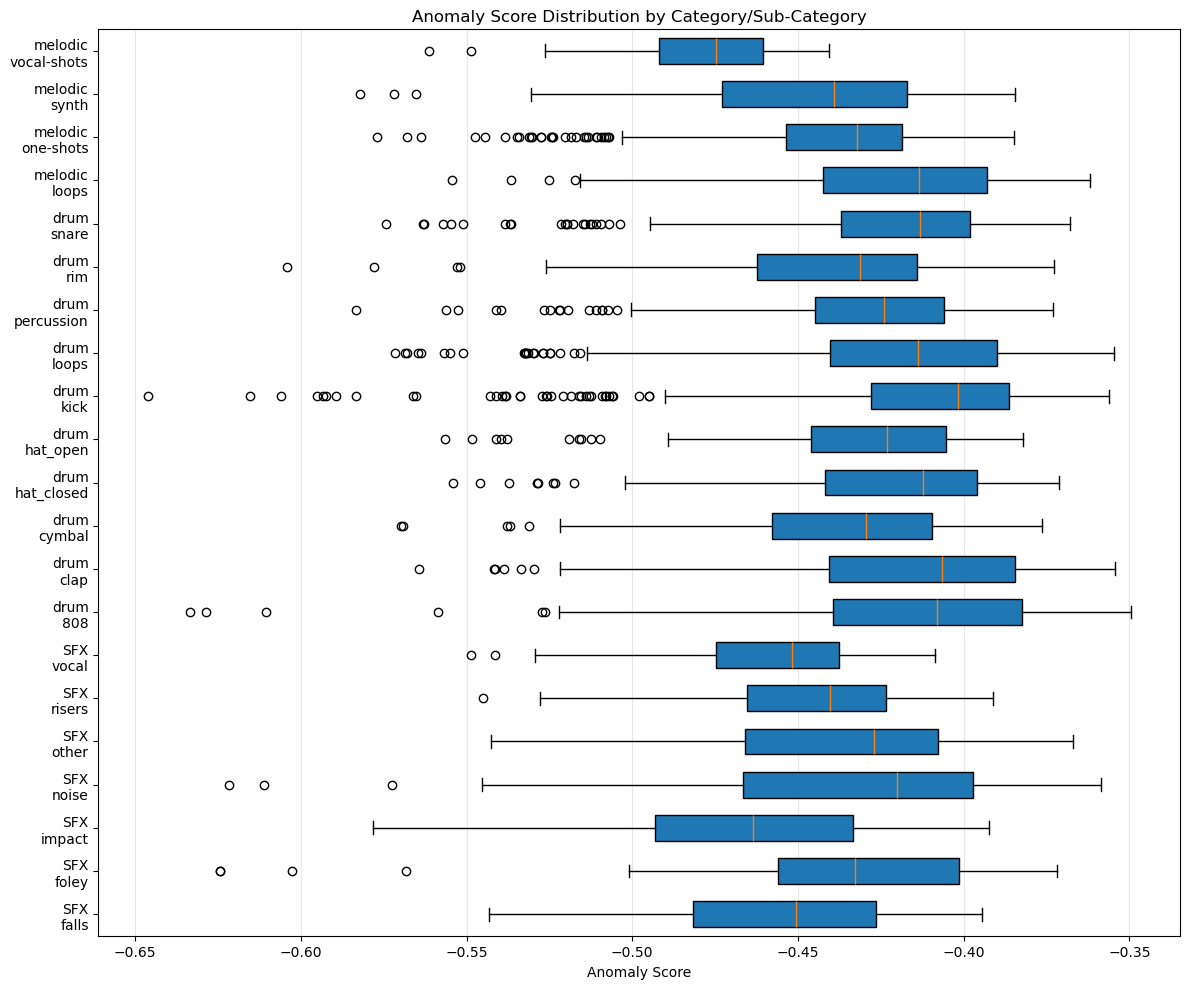

In [9]:
import matplotlib.pyplot as plt

# Get the data for plotting
plot_data = df_anomalies.groupby(["category", "sub_category"])["anomaly_score"].apply(
    list
)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Create horizontal boxplot
positions = range(len(plot_data))
bp = ax.boxplot(
    plot_data.values,
    positions=positions,
    widths=0.6,
    patch_artist=True,
    showfliers=True,
    vert=False,
)

# Customize the plot
ax.set_yticks(positions)
ax.set_yticklabels([f"{cat}\n{subcat}" for (cat, subcat) in plot_data.index])
ax.set_xlabel("Anomaly Score")
ax.set_title("Anomaly Score Distribution by Category/Sub-Category")
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

## Save to CSV for review and reclassification


In [10]:
df_top_10_pct = df_anomalies[df_anomalies["anomaly_percentile"] >= 0.9].copy()
df_top_10_pct.drop(["category", "sub_category"], axis=1, inplace=True)

In [11]:
df_top_10_pct.columns

Index(['anomaly_score', 'anomaly_percentile'], dtype='object')

In [12]:
import os


root_path = "/Users/jackcdawson/Desktop/dev/sample_identifier/pipeline/2_quality_check"
os.makedirs(f"{root_path}/anomaly_scores", exist_ok=True)

df_top_10_pct.to_csv(f"{root_path}/anomaly_scores/anomaly_scores_v1.csv", index=True)